# OSPP


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc

In [2]:
import protvi
import protvi.plots as pl
from protvi.benchmark_models import run_protDP
from protvi.utils import smoothing

import seaborn as sns

import scvi

from scib_metrics.benchmark import Benchmarker
import scib_metrics

In [3]:
sc.set_figure_params(frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

In [5]:
adata = sc.read("../../data/processed/wang2024_ospp_proteins.h5ad")

In [6]:
adata

AnnData object with n_obs × n_vars = 208 × 299
    obs: 'position', 'severity', 'sample_type', 'replicate', 'file_name', 'method'
    uns: 'method_colors', 'neighbors', 'pca', 'sample_type_colors', 'severity_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw'
    obsp: 'connectivities', 'distances'

Compute trends per dataset.

In [7]:
# adata = adata[adata.obs.sample_type.isin(['sample'])].copy()

x_dict = {}
yloess_dict = {}

adata_raw = adata.copy()
adata_raw.X = adata_raw.layers['raw'] .copy()


for x in adata.obs['method'].unique().tolist():
    detections = np.mean(~np.isnan(adata_raw[adata_raw.obs['method'].isin([x])].X), axis=0)
    ave_exp = np.nanmean(adata_raw[adata_raw.obs['method'].isin([x])].X, axis=0)
    mu_smooth, p_smooth = smoothing(ave_exp, detections)
    x_dict[x] = mu_smooth
    yloess_dict[x] = p_smooth


In [8]:
detections = np.mean(~np.isnan(adata_raw.X), axis=0)
ave_exp = np.nanmean(adata_raw.X, axis=0)
cv = np.nanstd(adata_raw.X, axis=0)/np.nanmean(adata_raw.X, axis=0)

colors = ['gray', 'blue', 'red', 'black']

j = np.where((detections < 0.1))[0] # seems to be batch (combination of plates)

outlier = np.repeat(False, len(detections))
outlier[j] = True


scF_df = pd.DataFrame({'x':ave_exp, 'y': detections, 'cv': cv ,'outlier': outlier} )

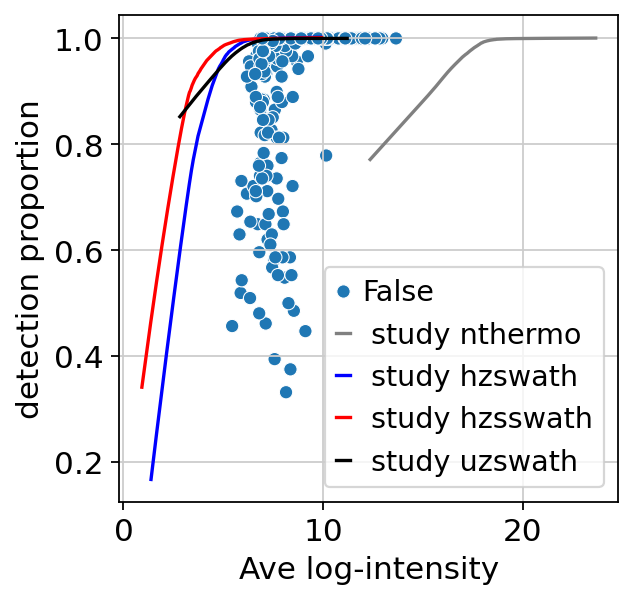

In [9]:
ax = sns.scatterplot(data = scF_df, x='x', y='y', hue= 'outlier')
ax.set(xlabel='Ave log-intensity', ylabel='detection proportion')

studies = adata.obs['method'].unique().tolist()

for i in range(len(studies)):
    study = studies[i]
    sns.lineplot(x = x_dict[study], y = yloess_dict[study], color=colors[i],  label=f' study {studies[i]}')
plt.show()

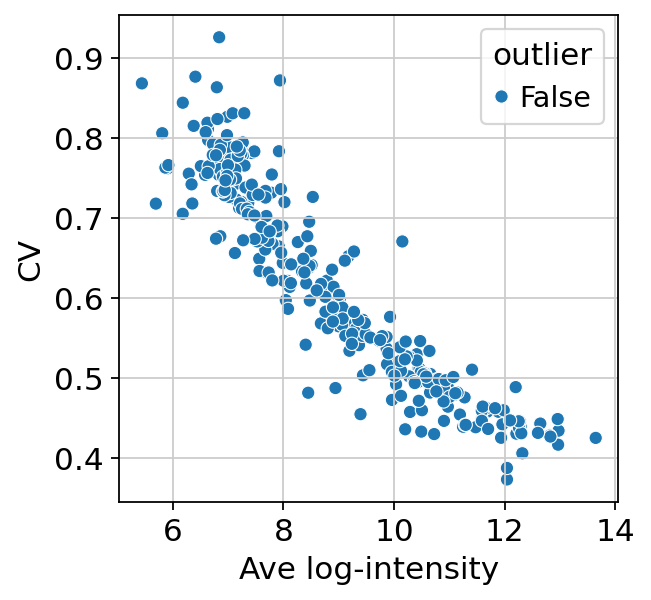

In [10]:
ax = sns.scatterplot(data = scF_df, x='x', y='cv', hue= 'outlier')
ax.set(xlabel='Ave log-intensity', ylabel='CV')
plt.show()

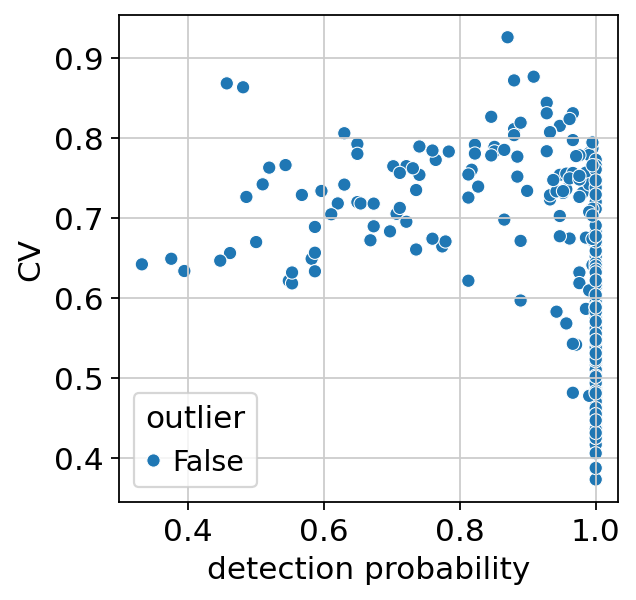

In [11]:
ax = sns.scatterplot(data = scF_df, x='y', y='cv', hue= 'outlier')
ax.set(xlabel='detection probability', ylabel='CV')
plt.show()

Compute mean sample size.


In [12]:
adata.obs['Num Proteins'] = (adata.X != 0).sum(1)

In [13]:
adata.obs['severity'] = adata.obs['severity'].astype('str')

Remove obs in "pool".


In [14]:
adata = adata[adata.obs.sample_type.isin(['sample'])].copy() # the position covariate is important if sample + pool are both considered

In [15]:
adata_ = adata.copy()
adata_.X = adata.layers['raw']

In [16]:
tech = {
    'hzsswath': 'TOF',
    'hzswath': 'TOF',
    'nthermo': 'Orbitrap',
    'uzswath': 'TOF'
}

adata.obs['tech'] = adata.obs['method'].map(tech)
adata_.obs['tech'] = adata.obs['method'].map(tech)

In [17]:
# sample_cv = adata_.to_df().copy().groupby(adata_.obs.method.tolist()).apply(lambda x: np.nanstd(x)/np.nanmean(x))
sample_cv = adata_.to_df().copy().groupby(adata_.obs.tech.tolist()).apply(lambda x: np.nanstd(x)/np.nanmean(x))
# adata.obs['sample_cv'] = sample_cv.values
adata.obs['sample_cv'] = adata.obs['tech'].map(sample_cv.to_dict())

In [18]:
sample_cv.to_dict()

{'Orbitrap': 0.1282295278661596, 'TOF': 0.3960626025662053}

In [19]:
adata.obs['method'].unique()

['nthermo', 'hzswath', 'hzsswath', 'uzswath']
Categories (4, object): ['hzsswath', 'hzswath', 'nthermo', 'uzswath']

hZSWATH + hZsSWATH are from same MS acquisition.


In [20]:
map_studies = {'hzswath': 'cohort 1', 'hzsswath': 'cohort 1', 'nthermo': 'cohort 2', 'uzswath': 'cohort 3'}

In [21]:
adata.obs['study'] = adata.obs['method'].map(map_studies)

Compute norm factors from pool samples or constant CV proteins.


In [22]:
x_raw = adata_[:,cv==0].X # zeros replaced with nans
x_raw = pd.DataFrame(x_raw)
# x_raw = np.log2(x_raw)


gm = np.exp(x_raw.mean(axis=0)) # data already on log-scale
rle_norm = x_raw.apply(lambda x: np.nanmedian((x/gm)[gm >0]), axis=1)
lib_total = x_raw.sum(axis=1)
rle_norm = rle_norm/lib_total
rle_norm = rle_norm/np.exp(np.mean(np.log(rle_norm)))

/home/rasmus/rmls/work/ra/MS_mv_modelling/.conda/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/rasmus/rmls/work/ra/MS_mv_modelling/.conda/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [23]:
adata.obs['rle_factors'] = rle_norm.values

In [24]:
adata.obs.head()

,position,severity,sample_type,replicate,file_name,method,Num Proteins,tech,sample_cv,study,rle_factors
s0,a1,moderate,sample,rep01,/s_mcpb_ms03/mirror/projectfiles_temporary/30_...,nthermo,276,Orbitrap,0.12823,cohort 2,NaN
s1,a2,healthy,sample,rep01,/s_mcpb_ms03/mirror/projectfiles_temporary/30_...,nthermo,270,Orbitrap,0.12823,cohort 2,NaN
s2,a3,healthy,sample,rep01,/s_mcpb_ms03/mirror/projectfiles_temporary/30_...,nthermo,278,Orbitrap,0.12823,cohort 2,NaN
s3,a4,healthy,sample,rep01,/s_mcpb_ms03/mirror/projectfiles_temporary/30_...,nthermo,285,Orbitrap,0.12823,cohort 2,NaN
s4,a5,mild,sample,rep01,/s_mcpb_ms03/mirror/projectfiles_temporary/30_...,nthermo,284,Orbitrap,0.12823,cohort 2,NaN


In [25]:
# adata = adata[adata.obs['method'].isin(['hzswath','hzsswath','uzswath'])].copy()

# adata = adata[~adata.obs['method'].isin(['hzswath','hzsswath'])].copy()

In [26]:
adata.X = adata.layers["raw"].copy()
adata.X[np.isnan(adata.X)] = 0

In [27]:
protvi.model.PROTVI.setup_anndata(adata,
                     # batch_key = "method", 
                     batch_key = "tech", 
                     # prior_categorical_covariate_keys = ['severity'],
                     categorical_covariate_keys = ['method'], # 'study', 'position', 'method', 'tech'
                     continuous_covariate_keys= ["Num Proteins"],
                     detection_trend_key = ["tech"],
                     # norm_continuous_covariate_keys = ['sample_cv'], # 'sample_cv', 'rle_factors'
                     # categorical_covariate_keys = ['File ID'],
                     # continuous_covariate_keys= ['sample_cv'],
                     # categorical_covariate_keys = ['Plate', 'Channel'],
                     # continuous_covariate_keys=["Log2 Sum S/N"], # "d2c", "Log2 Sum S/N", "Num Proteins"
                     # norm_continuous_covariate_keys = ['rle_norm'], # 'cv_offset', 'sample_cv', 'rle_norm'
                     # prior_continuous_covariate_keys = ['CD34-APC-Cy7-A','CD38-PE-A'],
)

In [28]:
model = protvi.model.PROTVI(adata, log_variational=False, 
                            n_hidden=225, n_layers=2, n_latent = 20,
                            encode_norm_factors=False, use_x_mix=False, 
                            decoder_type = 'selection', detection_trend="per-batch") # detection_trend="per-batch"

/home/rasmus/rmls/work/ra/MS_mv_modelling/.conda/lib/python3.11/site-packages/torch/nn/init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [38]:
model.train(max_epochs=10000, plan_kwargs={"mechanism_weight": 0.50, 'kl_weight':1, 'n_epochs_kl_warmup': 10}, check_val_every_n_epoch=120)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/rasmus/rmls/work/ra/MS_mv_modelling/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/rasmus/rmls/work/ra/MS_mv_modelling/.conda/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 127/10000:   1%|▏         | 126/10000 [00:03<04:43, 34.80it/s, v_num=1, train_loss_step=736, train_loss_epoch=475]      

/home/rasmus/rmls/work/ra/MS_mv_modelling/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 10000/10000: 100%|██████████| 10000/10000 [07:50<00:00, 23.03it/s, v_num=1, train_loss_step=31.8, train_loss_epoch=17.2]   

`Trainer.fit` stopped: `max_epochs=10000` reached.


Epoch 10000/10000: 100%|██████████| 10000/10000 [07:50<00:00, 21.25it/s, v_num=1, train_loss_step=31.8, train_loss_epoch=17.2]


/home/rasmus/rmls/work/ra/MS_mv_modelling/src/protvi/plots.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2281.575439453125 1049.6829833984375 660.9232788085938 649.3255004882812
 840.6728515625 818.6142578125 457.0191650390625 1007.6182861328125
 515.0037231445312 1221.1837158203125]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  history[new_key].iloc[:window] = history[key].iloc[:window]
/home/rasmus/rmls/work/ra/MS_mv_modelling/src/protvi/plots.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2262.973876953125 1035.58642578125 647.845947265625 638.9799194335938
 831.507080078125 810.0838623046875 450.88372802734375 1001.6499633789062
 511.13531494140625 1216.29052734375]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  hi

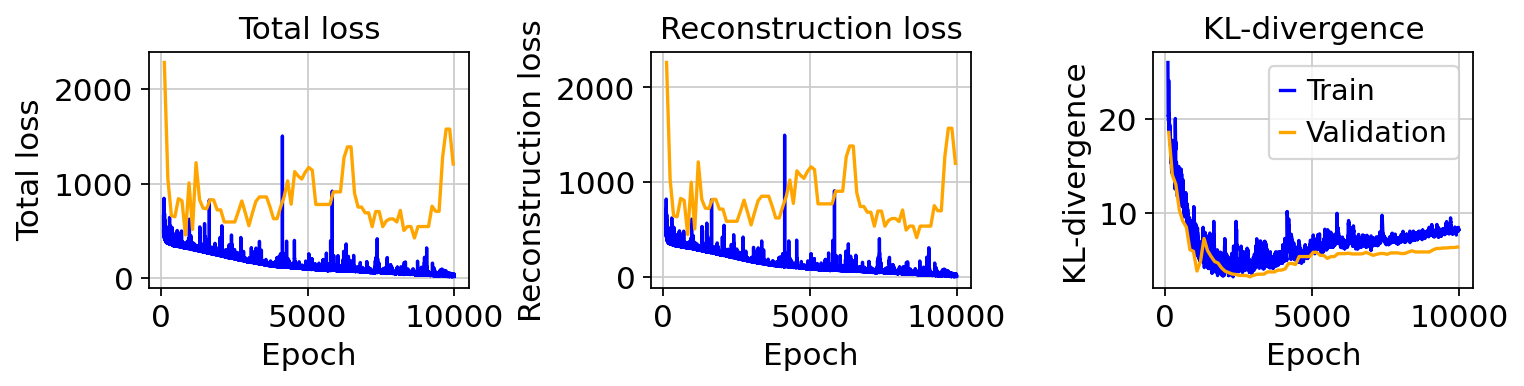

In [39]:
pl.plot_loss(model.history, epoch_start=90, validation_smooth_window=10)

In [49]:
model.save("protvi")

In [29]:
model = protvi.model.PROTVI.load("protvi", adata)

INFO     File protvi.pkl/model.pt already downloaded                                                               


/home/rasmus/rmls/work/ra/MS_mv_modelling/.conda/lib/python3.11/site-packages/scvi/model/base/_utils.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(

In [30]:
latent = model.get_latent_representation()
adata.obsm["latent"] = latent

In [31]:
adata_latent = sc.AnnData(X = latent, obs = adata.obs)
sc.pp.pca(adata_latent)
adata.obsm['latent_X_pca'] = adata_latent.obsm['X_pca']

Plot PCA of the latent space.


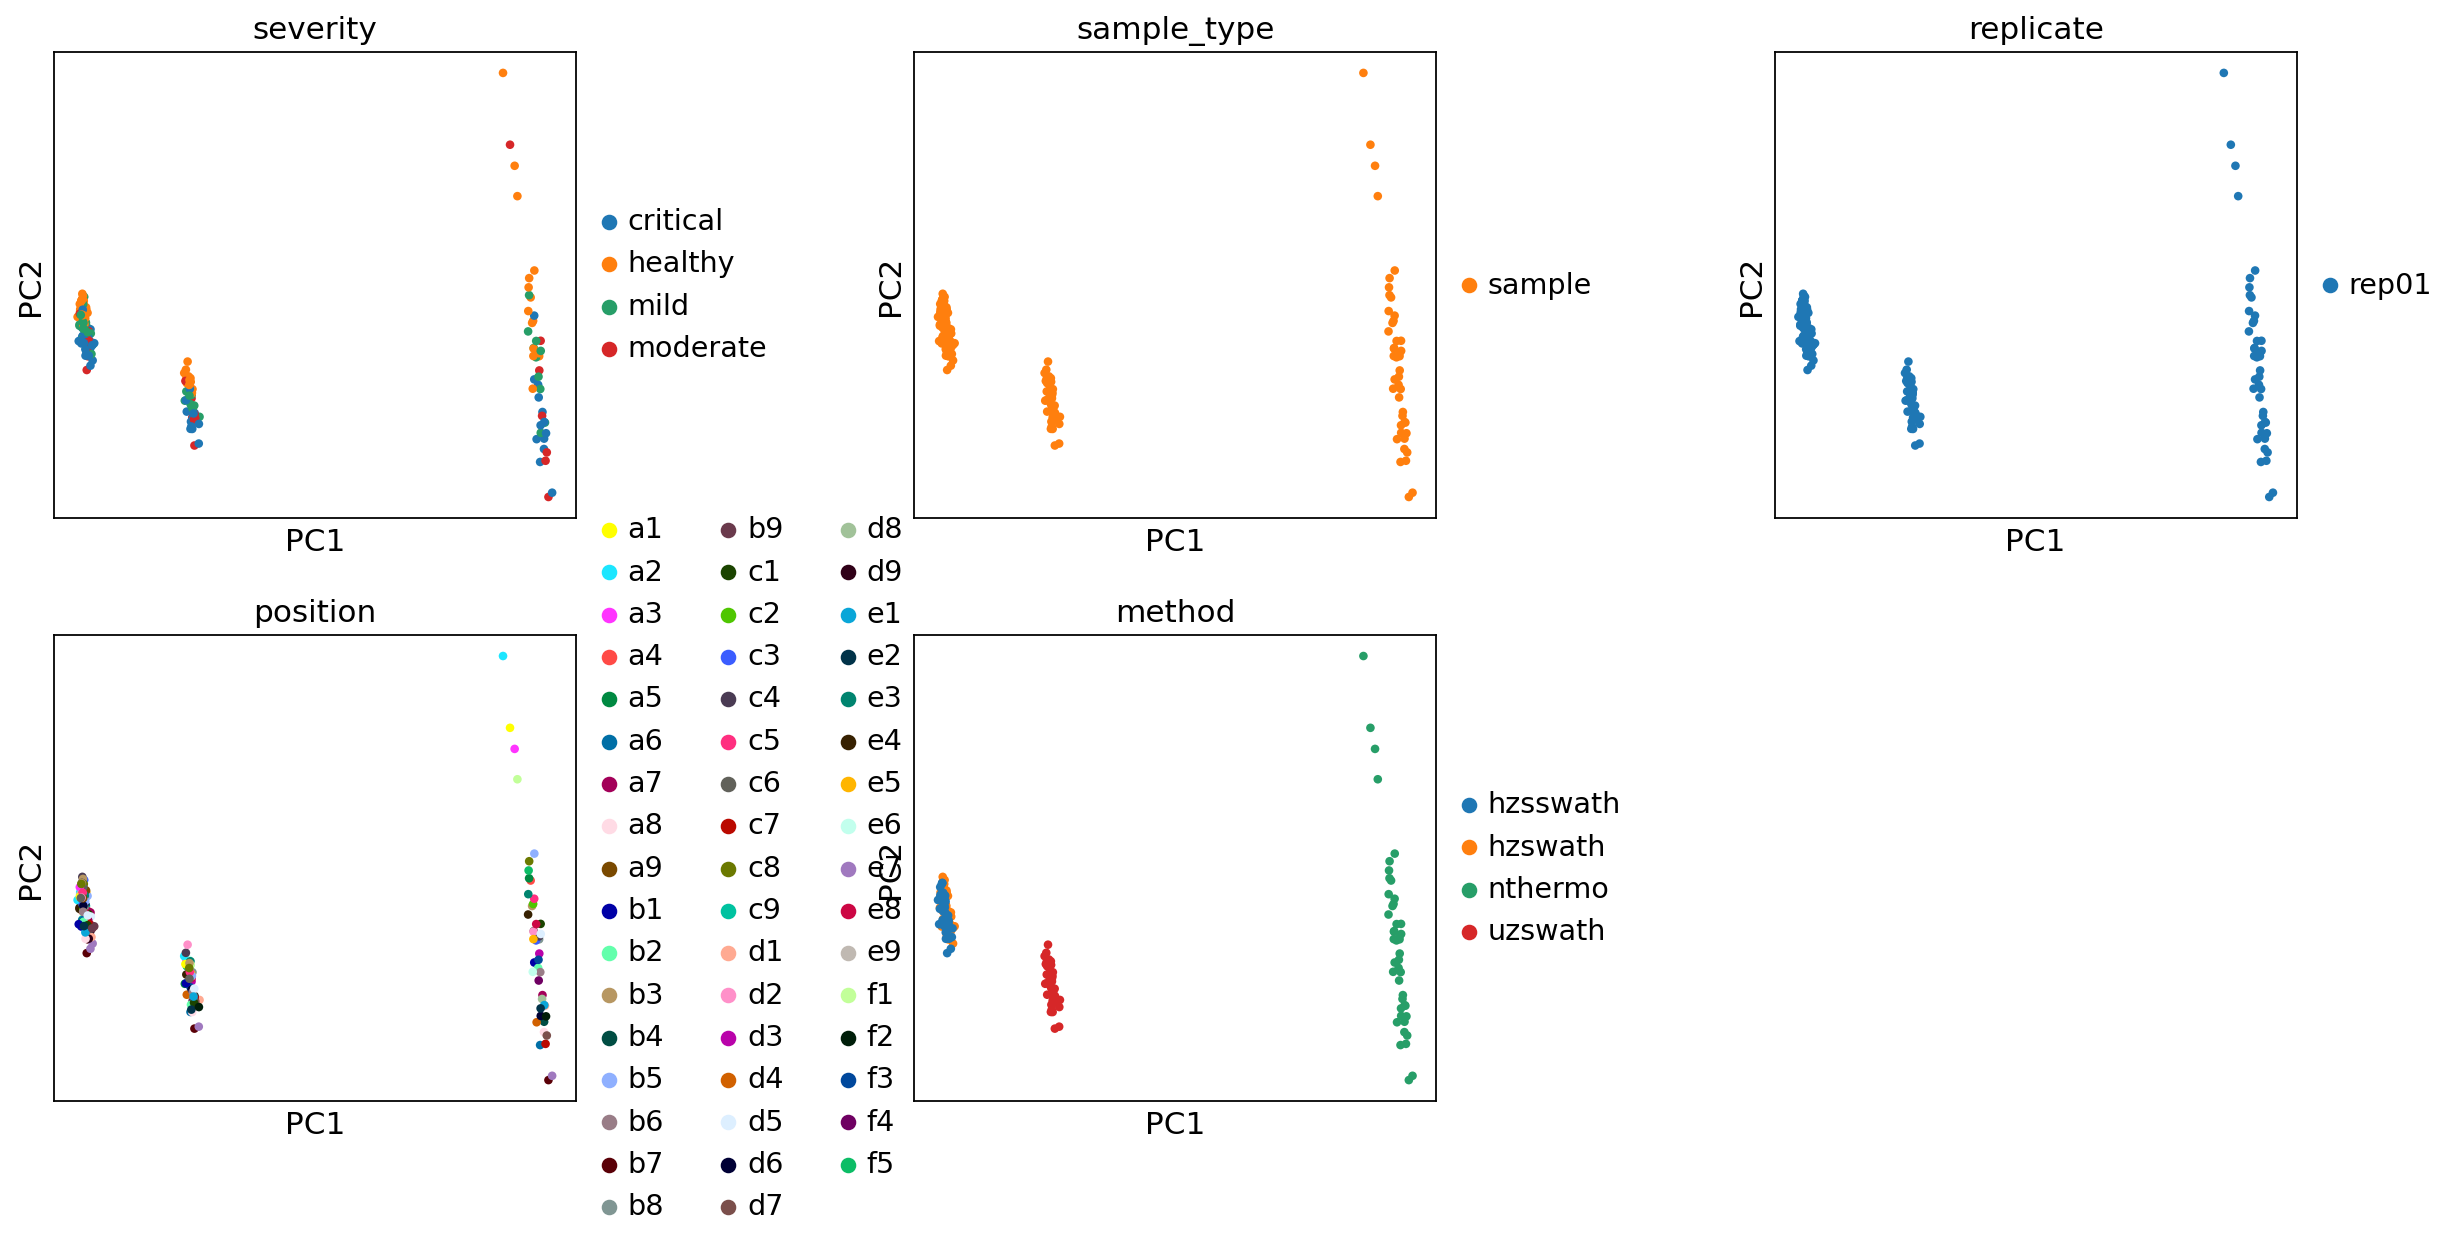

In [32]:
sc.pl.pca(
    adata,
    color=[ 'severity', 'sample_type', 'replicate', 'position', 'method'], 
    vmin="p01", vmax="p99",ncols = 3, wspace = 0.5, size = 60,
)

In [33]:
adata_latent.uns['severity_colors'] = list(sns.color_palette('Dark2', n_colors = 4).as_hex())

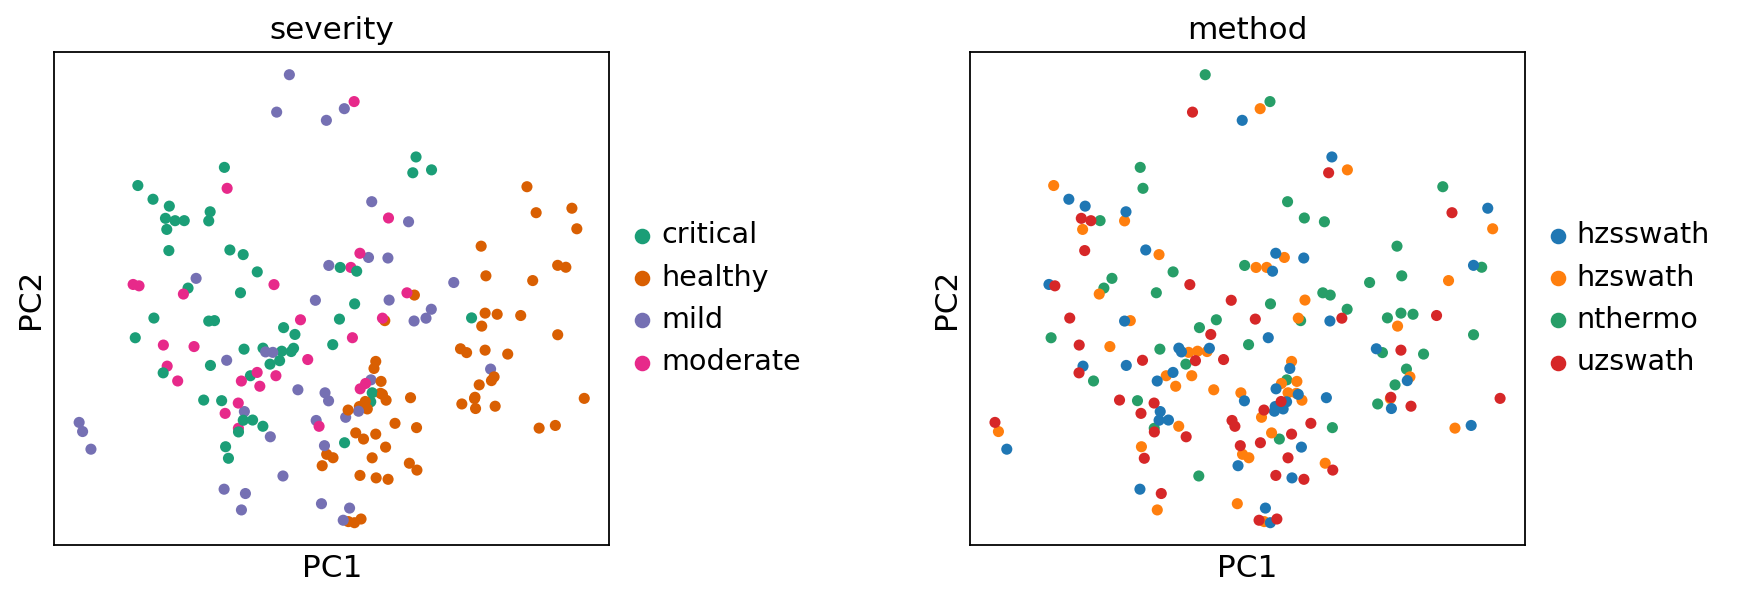

In [34]:
sc.pl.pca(
    adata_latent, 
    color=[ 'severity',  'method' ], 
    vmin="p01", vmax="p99",ncols = 3, wspace = 0.5, size = 100,
    # save = 'COVID_cross_study_correction.png'
)

In [35]:
sc.pp.neighbors(adata, use_rep="latent")
sc.tl.umap(adata)

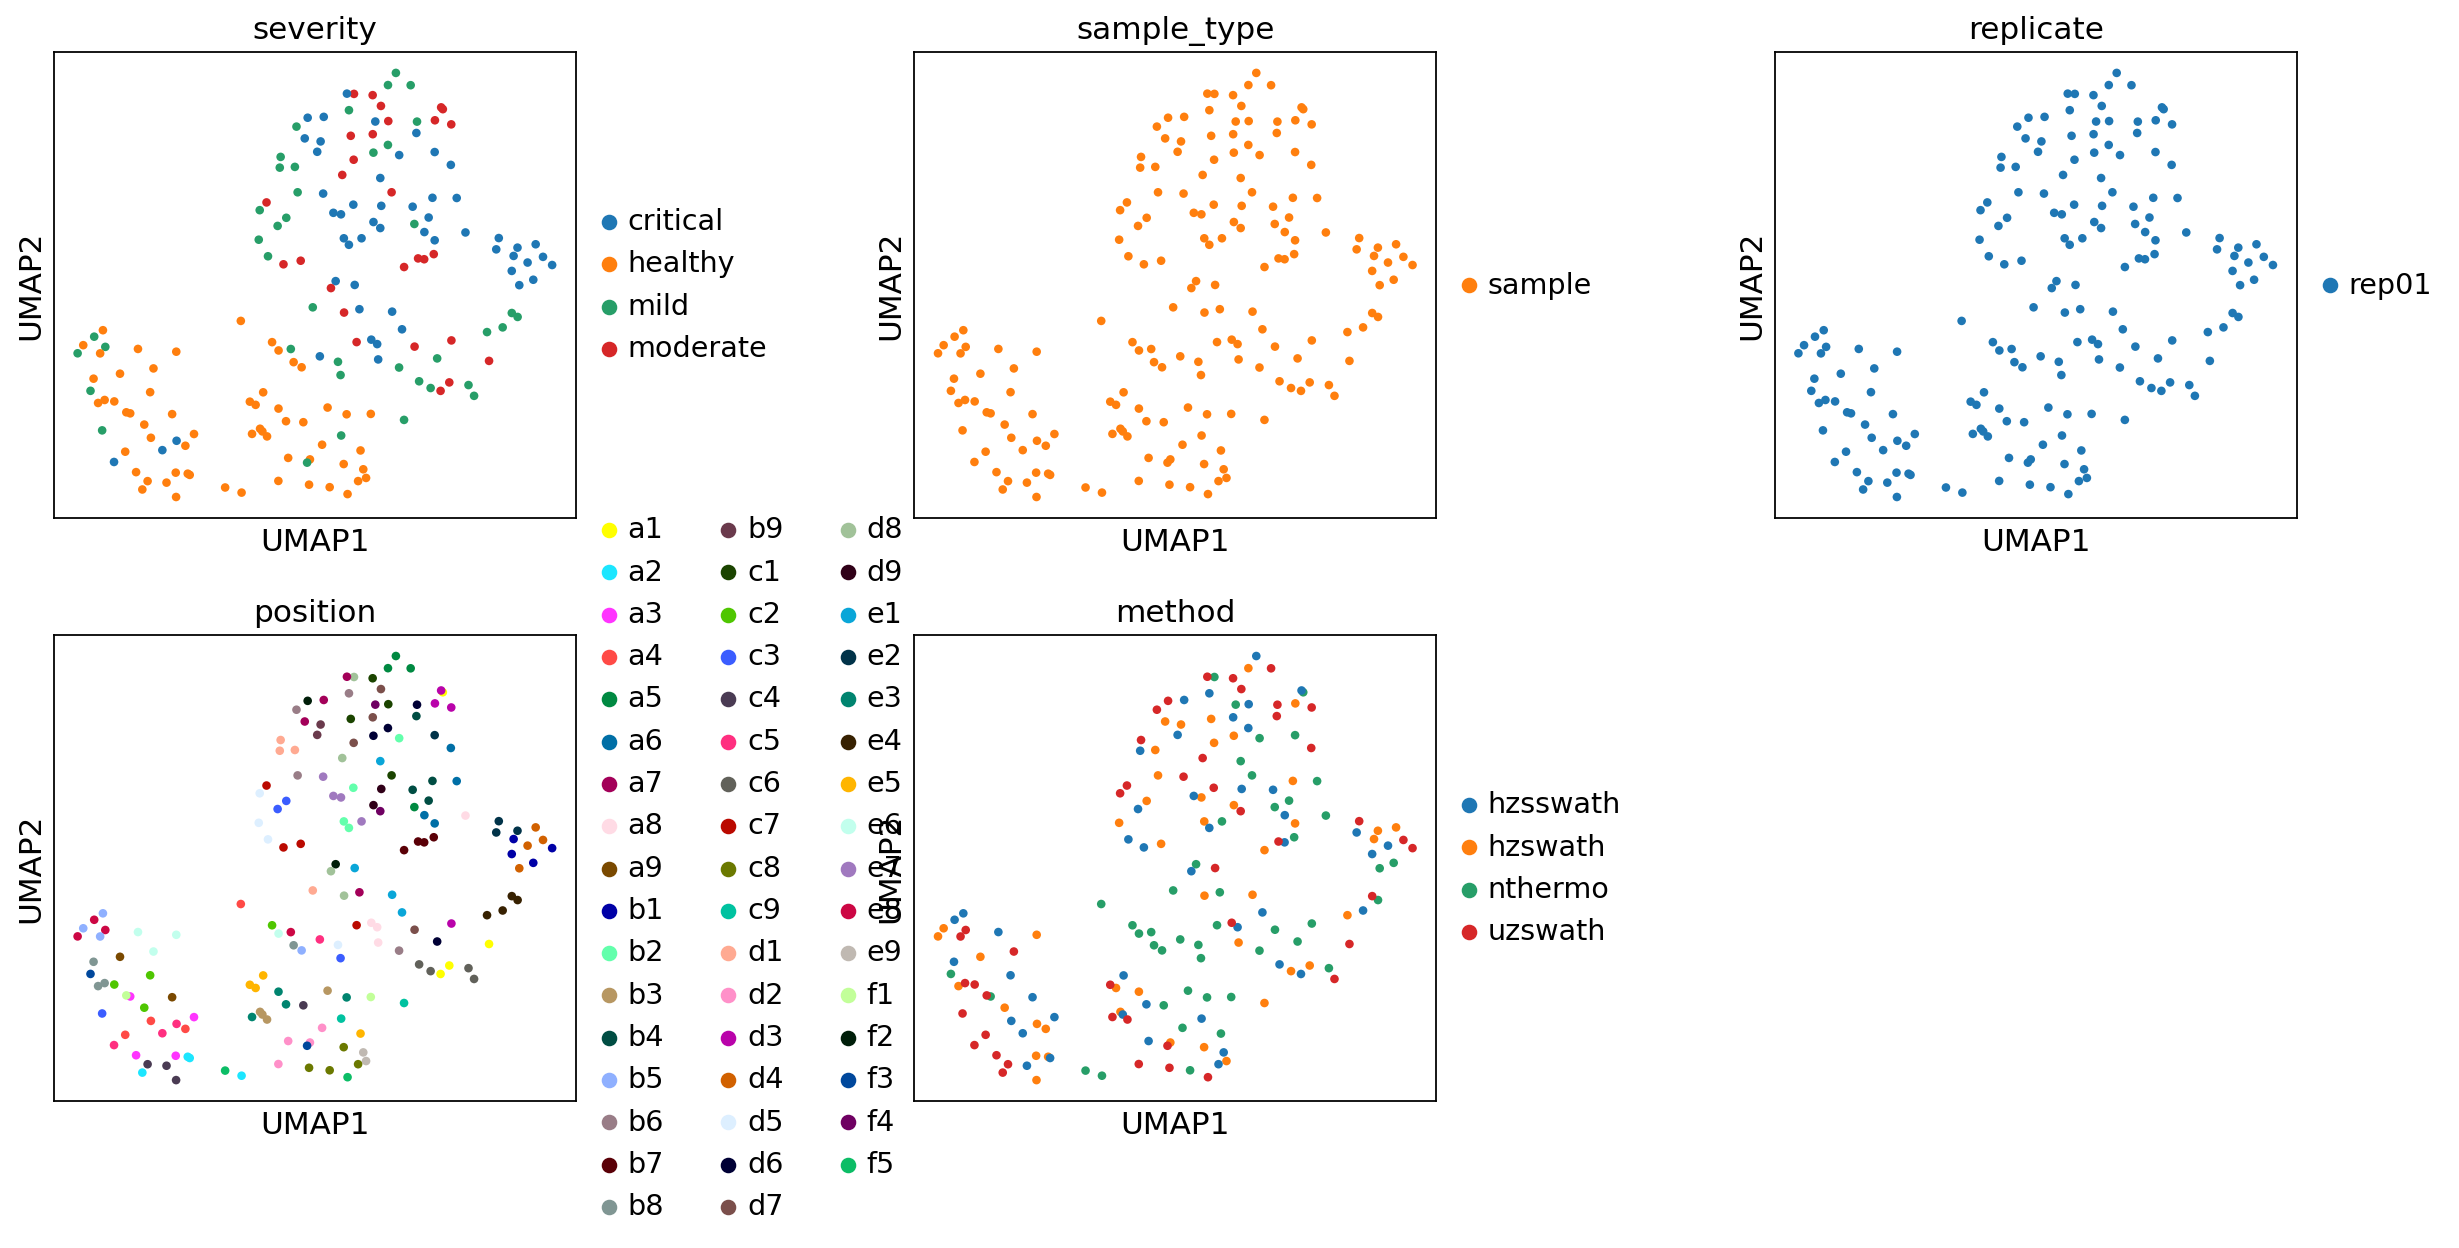

In [36]:
sc.pl.umap(
    adata, 
    color=[ 'severity', 'sample_type', 'replicate', 'position', 'method' ], 
    vmin="p01", vmax="p99",ncols = 3, wspace = 0.5, size = 60,
)

Plot the detection probability trend.

In [33]:
x_est, p_est = model.impute(n_samples=adata.n_obs, batch_size = 1)

x_data = adata.layers["raw"]

x_est_obs = x_est.copy()
x_est_obs[np.isnan(x_data)] = np.nan

x_est_miss = x_est.copy()
x_est_miss[~np.isnan(x_data)] = np.nan

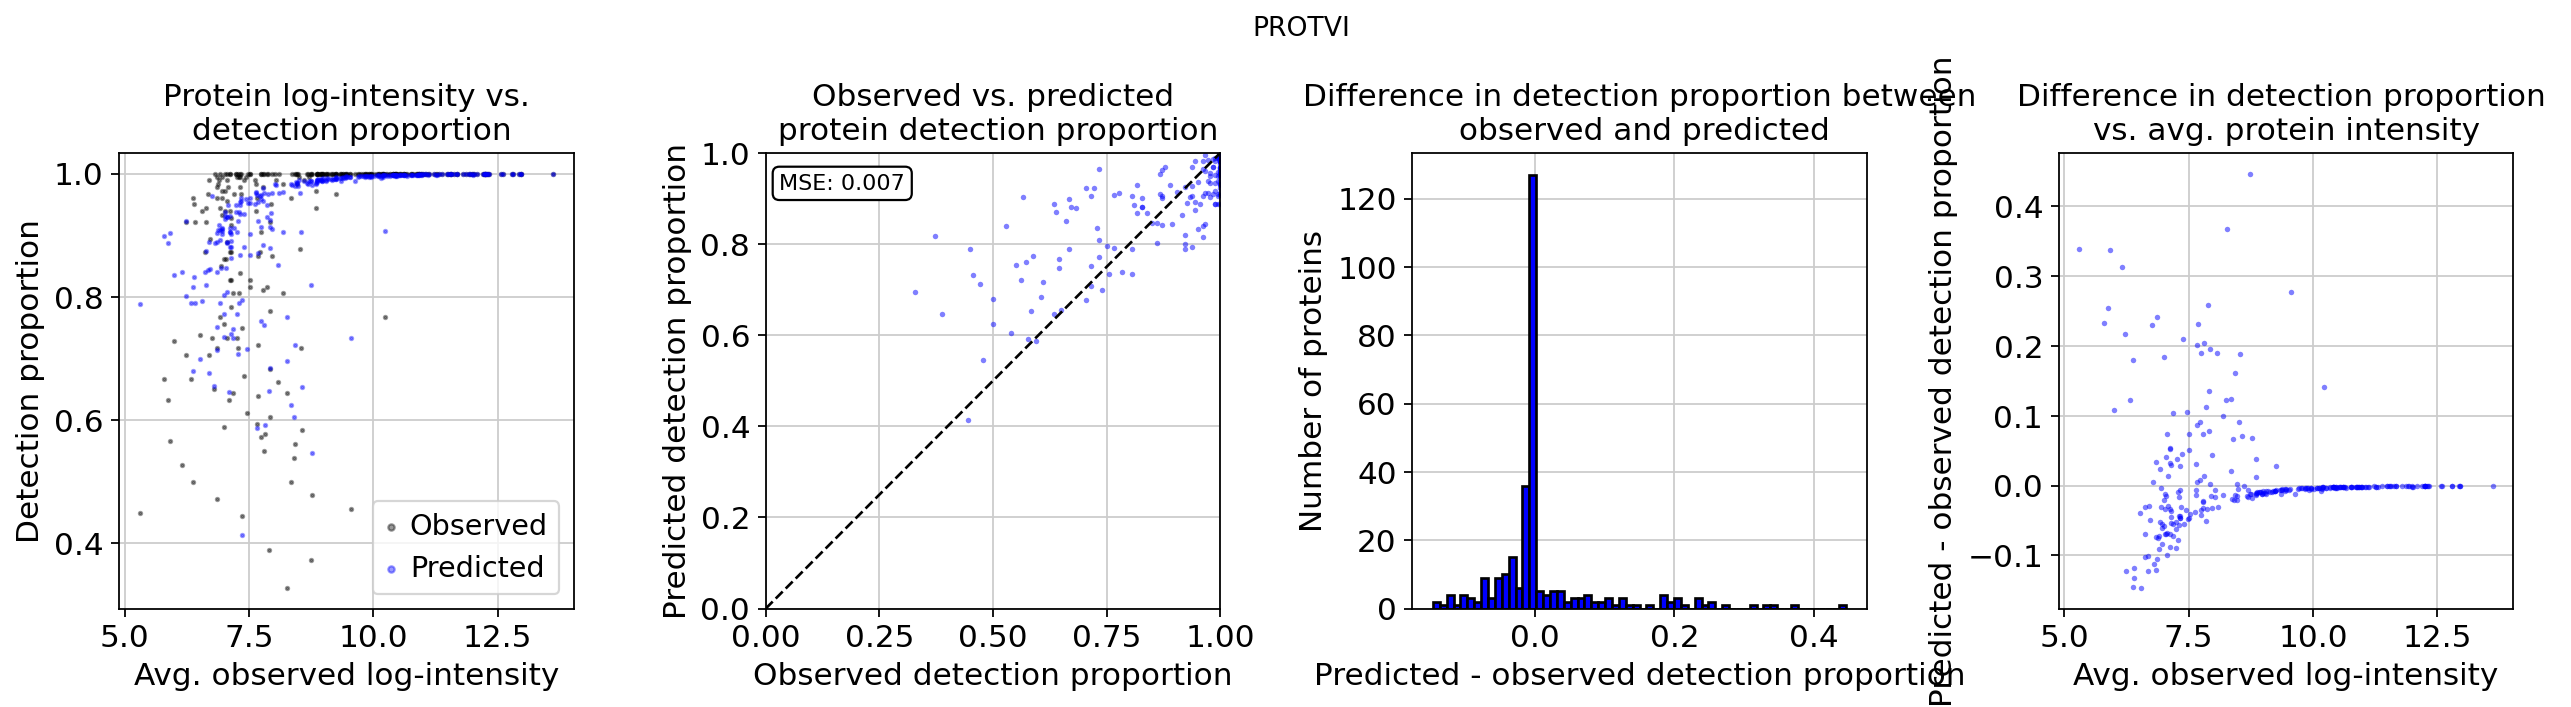

In [34]:
pl.plot_protein_detection_proportion_panel(x_data, p_est, title="PROTVI")

In [52]:
detections = np.mean(p_est, axis=0)
ave_exp = np.nanmean(adata.layers['raw'], axis=0)

mu_smooth, p_smooth = smoothing(ave_exp, detections, lowess_frac = 0.3)

x_dict['protVI'] = mu_smooth
yloess_dict['protVI'] = p_smooth

## protDP


Let's also train [protDP](https://mengbo-li.github.io/protDP/index.html) for later comparison.


In [36]:
adata.X = adata.layers["raw"].copy()

In [37]:
%%capture
protdp_result = run_protDP(adata)

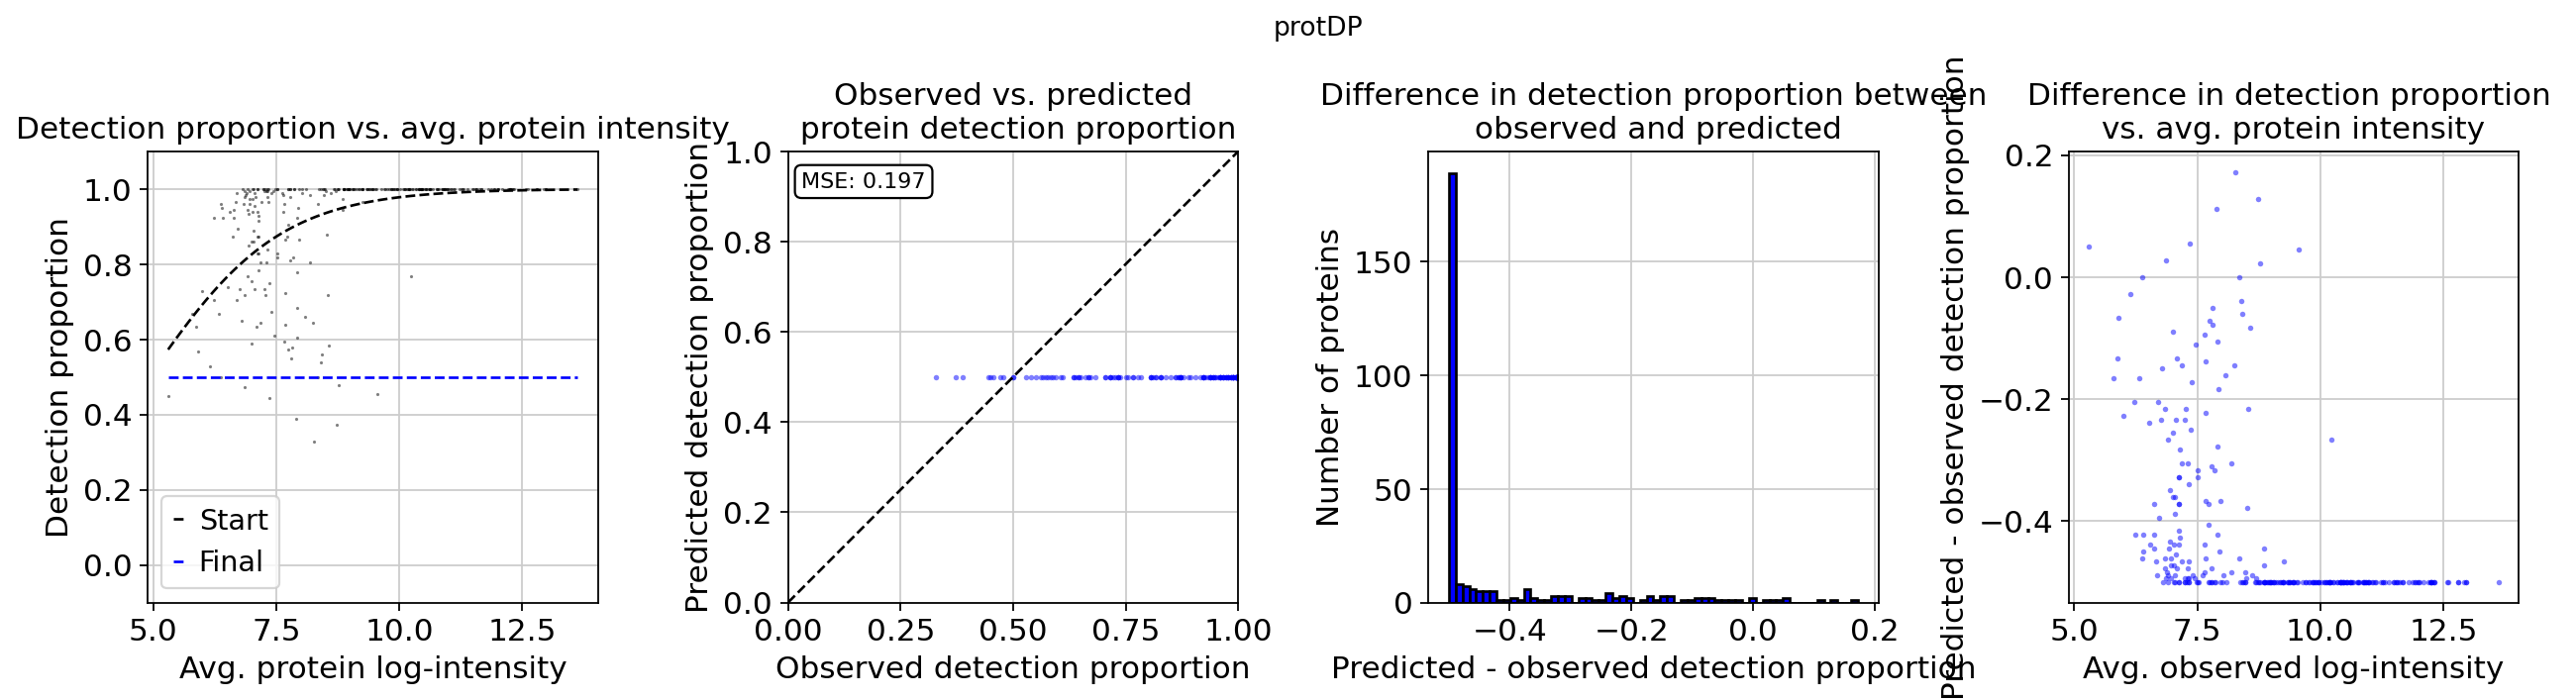

In [38]:
pl.plot_protein_detection_proportion_panel_protDP(adata.X, protdp_result, title="protDP")

In [40]:
PROTDP_OUTPUT_NAME = "wang2024_ospp_protdp.pkl"

import pickle

with open(PROTDP_OUTPUT_NAME, 'wb') as f:
    pickle.dump(protdp_result, f)

Plot global detection curves.

In [41]:
x = adata.layers['raw'].copy()

Text(0.5, 1.0, 'detection probability curves')

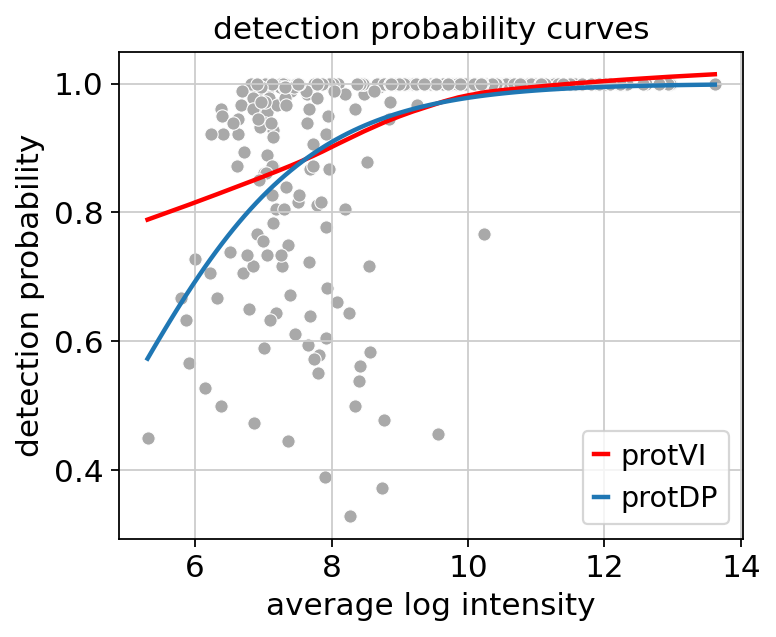

In [53]:
x_protein = np.nanmean(x, axis=0)
p_protein = 1 - np.mean(np.isnan(x), axis=0)
p_est_protein = p_est.mean(axis=0)

fig, ax = plt.subplots(figsize=(5, 4), ncols=1)
ax = sns.scatterplot(x=x_protein, y=p_protein, color="darkgrey")

# protVI
idx = np.argsort(x_dict['protVI'])
ax.plot(x_dict['protVI'][idx], yloess_dict['protVI'][idx], label="protVI", linewidth=2, color='red')

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# protDP
intercept, slope = protdp_result["betaStart"] # for some reason the corrected beta is odd, so use the uncorrected. 
xs = np.linspace(np.min(x_protein), np.max(x_protein), 100)
ys = sigmoid(slope * xs + intercept)
ax.plot(xs, ys, label="protDP", linewidth=2)
ax.legend()

ax.set_xlabel("average log intensity")
ax.set_ylabel("detection probability")
ax.set_title("detection probability curves")

#plt.savefig("wang2024_ospp_detection_probability_curves.svg")

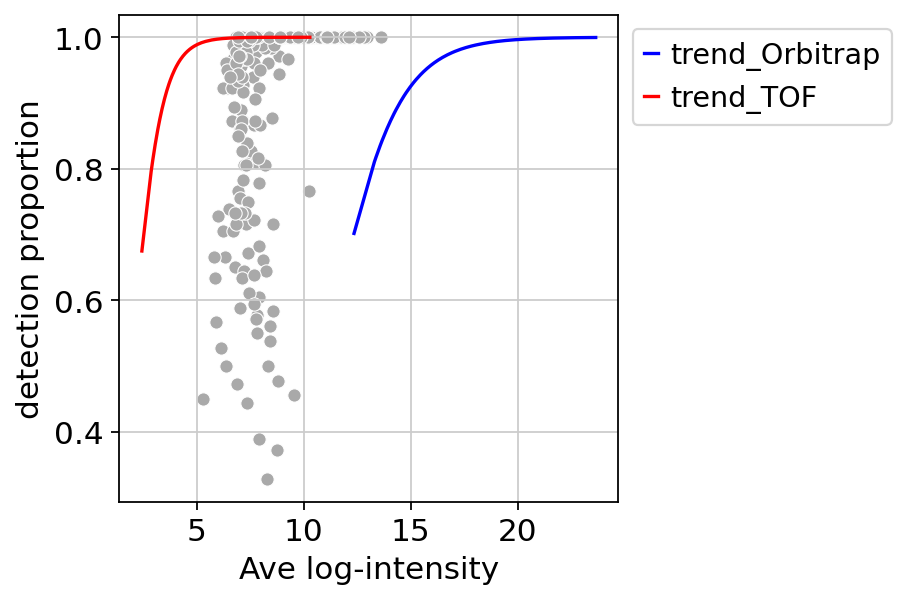

In [48]:
pl.plot_detection_curve(model, adata, detection_trend_key="tech", colors=["blue", "red"])

Plot all protVI's detection curves. 

In [49]:
def sigmoid(x):
        return 1 / (1 + np.exp(-x))

slope, intercept = model.module.decoder.get_mask_logit_weights()

groupvar = 'tech'

for i in range(len(adata.obs[groupvar].unique())):
    group = adata.obs[groupvar].unique()[i]
    aveExp = np.nanmean(adata[adata.obs[groupvar].isin([group])].layers['raw'], axis=0)
    ys = sigmoid(slope[i] * aveExp + intercept[i])
    x_dict[f'protVI_batch{i}'] = aveExp # or the fit from loess?
    yloess_dict[f'protVI_batch{i}'] = ys
    

nthermo
hzswath
hzsswath
uzswath
protVI
protVI_batch0
protVI_batch1


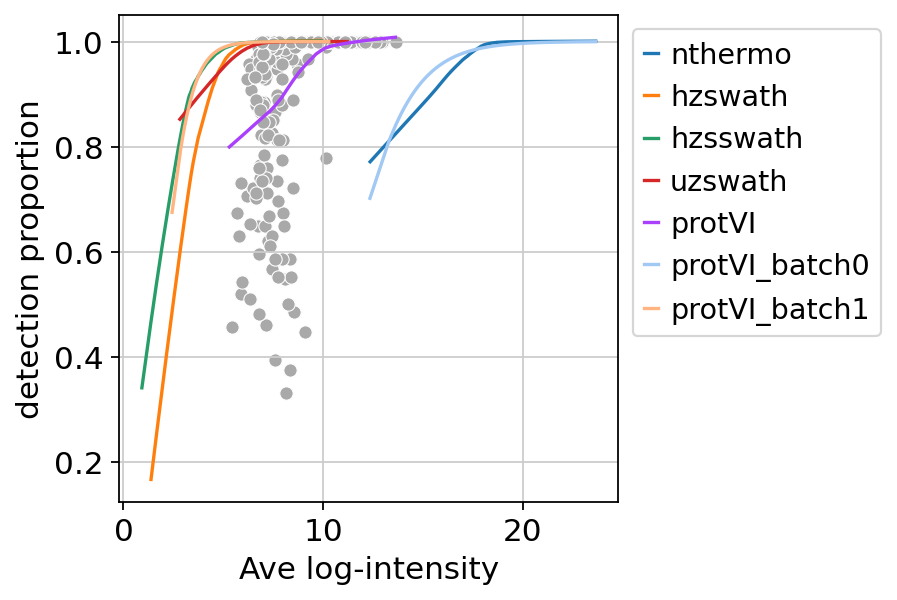

In [50]:
ax = sns.scatterplot(data = scF_df, x='x', y='y', color="darkgrey")
ax.set(xlabel='Ave log-intensity', ylabel='detection proportion')

colors = ['gray', 'blue', 'red', 'black', 'green']

curves = list(x_dict.keys())
colors = list(sns.color_palette(n_colors=5).as_hex()) + list(sns.color_palette('pastel',n_colors=4).as_hex())

for i in range(len(curves)):
    study = curves[i]
    print(study)
    sns.lineplot(x = x_dict[study], y = yloess_dict[study], color=colors[i],  label=f'{curves[i]}')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#plt.savefig('batch_specific_detection_curves.png', bbox_inches='tight')

Override X_pca for benchmarking.

In [52]:
adata.X = adata.layers['raw']
adata.X[np.isnan(adata.X)] = 0

sc.pp.pca(adata)

## Baselines


In [53]:
import scipy as sp
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA  
import magic
import scanorama
import anndata as ad

#### KNN-ComBat


In [54]:
imputer = KNNImputer(n_neighbors=100) 
features = imputer.fit_transform(adata.layers['raw'].copy())

# construct anndata data file
cell_nums, protein_nums = features.shape[0], features.shape[1]
cell_name = list(range(cell_nums))
protein_name = list(range(protein_nums))
var = pd.DataFrame(index = protein_name)
obs = pd.DataFrame(index = cell_name)
adata_knn = ad.AnnData(features,obs=obs,var=var)
adata_knn.obs['batch'] = adata.obs['method'].tolist()

combat_data = adata_knn.copy()
sc.pp.combat(combat_data, key = 'batch')
# sc.pp.combat(combat_data)
features_combat = combat_data.X
sc.pp.pca(combat_data)
# adata.obsm['X_knnCombat'] = features_combat
adata.obsm['X_knnCombat'] = combat_data.obsm['X_pca']

/home/rasmus/rmls/work/ra/MS_mv_modelling/.conda/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/rasmus/rmls/work/ra/MS_mv_modelling/.conda/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [55]:
combat_data.obs = adata.obs

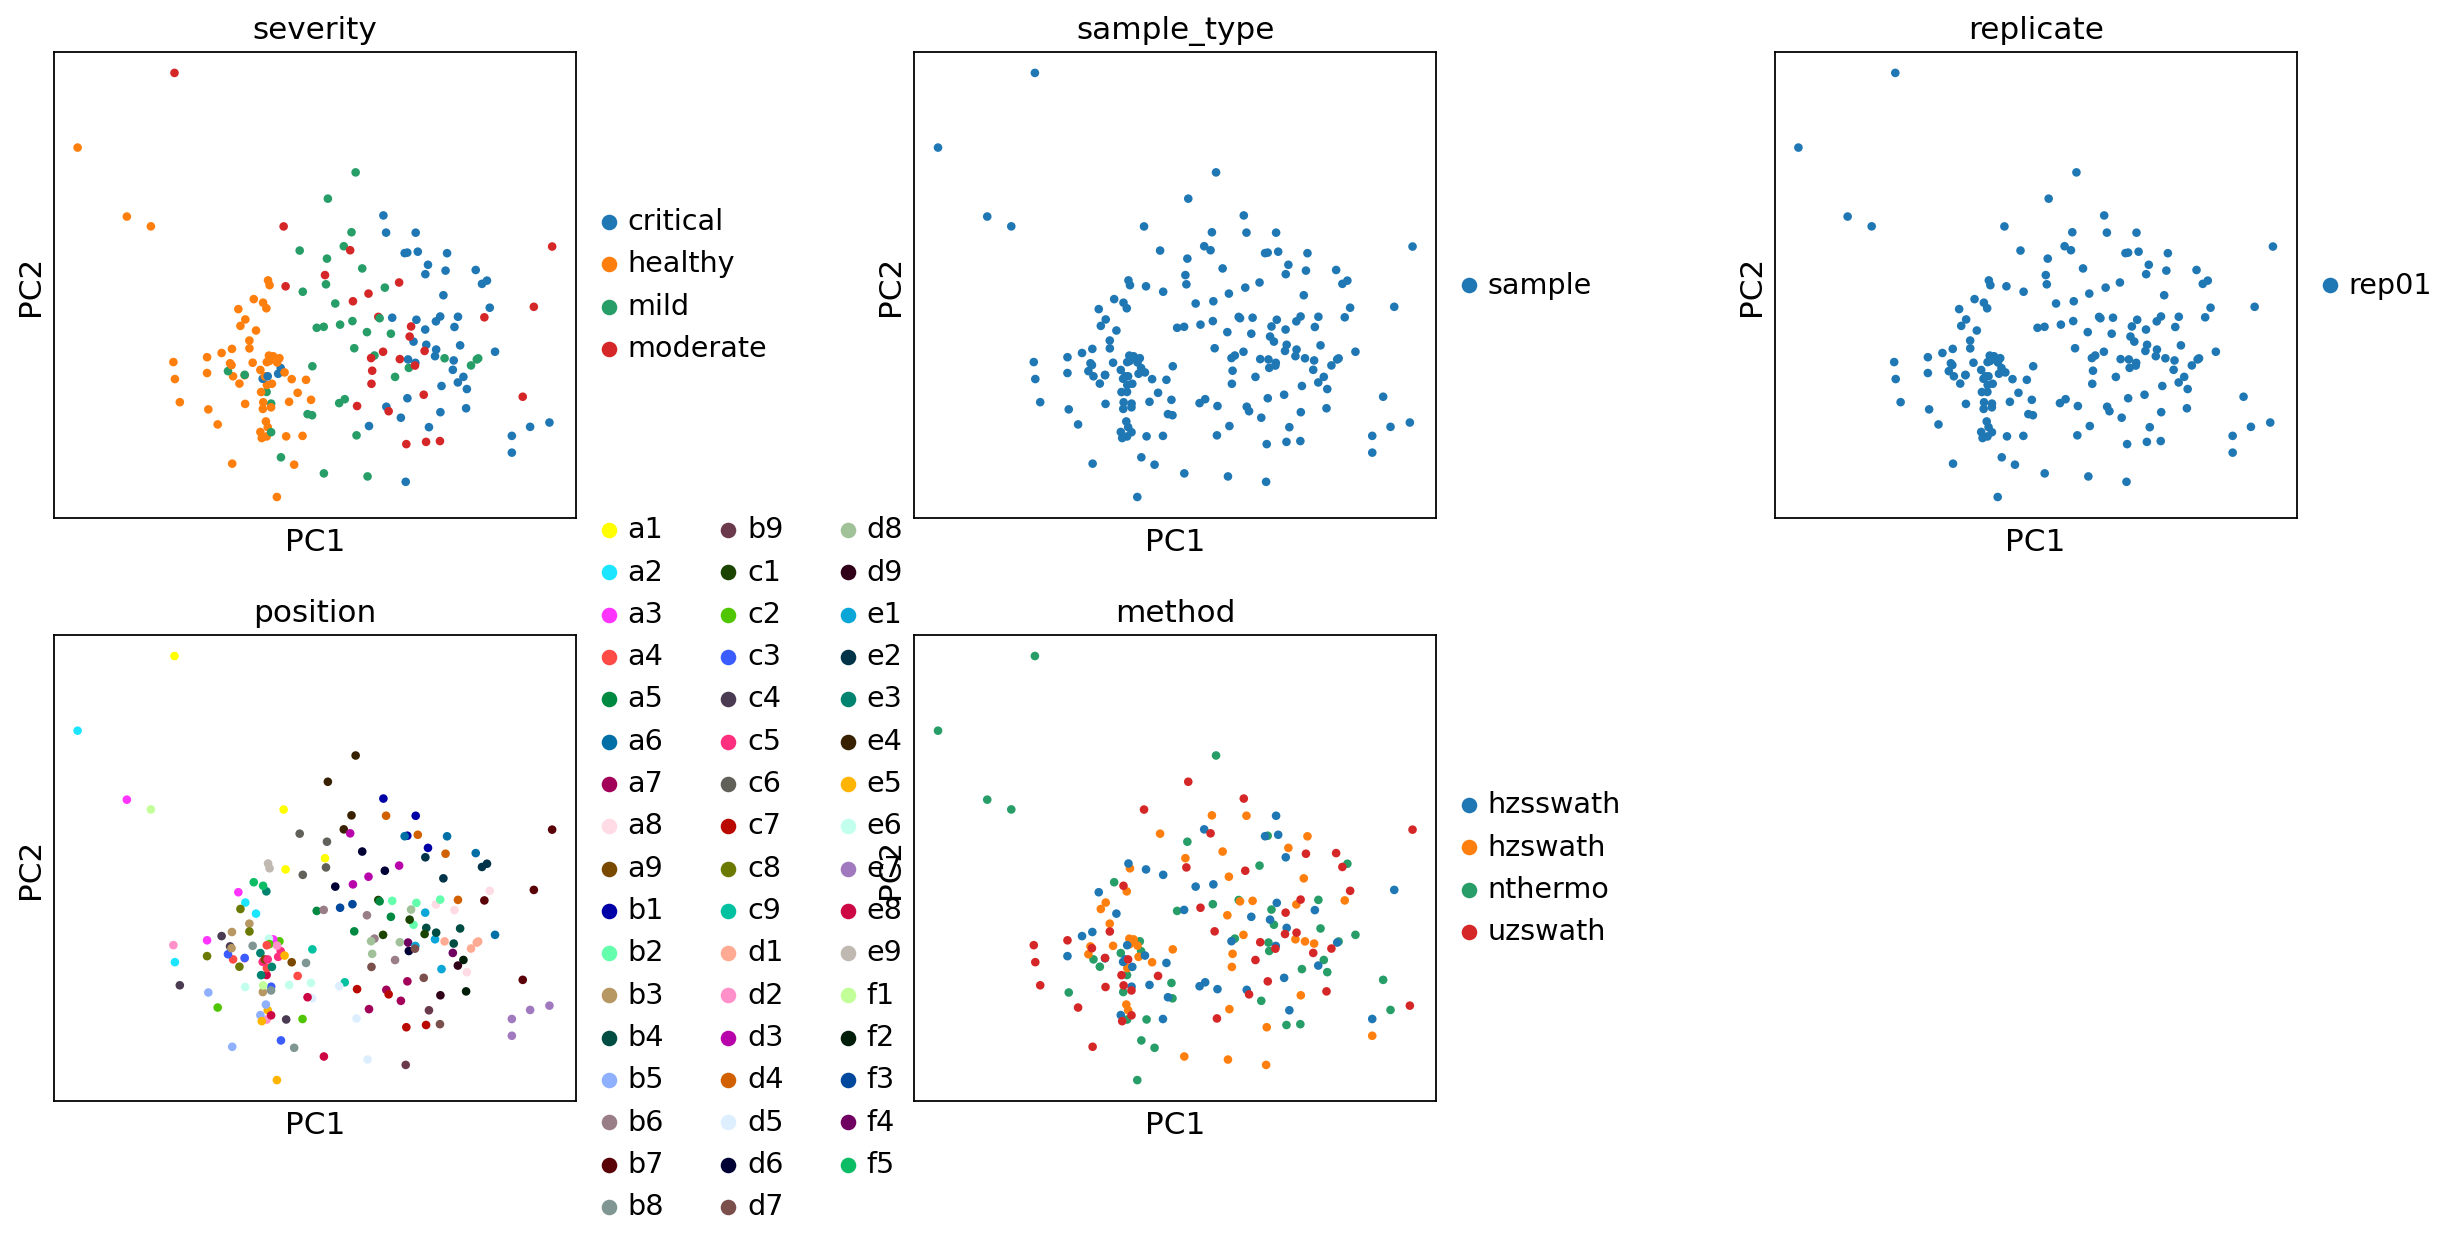

In [56]:
sc.pl.pca(
    combat_data, 
    color=[ 'severity', 'sample_type', 'replicate', 'position', 'method' 
        ], 
    
    vmin="p01", vmax="p99",ncols = 3, wspace = 0.5, size = 60,
)

#### MAGIC


In [57]:
magic_operator = magic.MAGIC()
features_magic = magic_operator.fit_transform(adata.X.copy())
# np.save('{}_feature.npy'.format(baseline),features_magic)
adata.obsm['X_magic'] = features_magic

Calculating MAGIC...


  Running MAGIC on 180 cells and 299 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.74 seconds.
    Calculating KNN search...
    Calculating affinities...
  Calculated graph and diffusion operator in 0.75 seconds.
  Calculating imputation...
  Calculated imputation in 0.03 seconds.
Calculated MAGIC in 0.79 seconds.


### Harmony


In [58]:
adata_knn.obs['batch'] = adata.obs['method'].tolist()
sc.pp.pca(adata_knn)
sc.external.pp.harmony_integrate(adata_knn, key = 'batch')

2024-08-05 12:53:30,280 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-08-05 12:53:30,379 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-08-05 12:53:30,380 - harmonypy - INFO - Iteration 1 of 10
2024-08-05 12:53:30,398 - harmonypy - INFO - Iteration 2 of 10
2024-08-05 12:53:30,404 - harmonypy - INFO - Iteration 3 of 10
2024-08-05 12:53:30,409 - harmonypy - INFO - Iteration 4 of 10
2024-08-05 12:53:30,415 - harmonypy - INFO - Converged after 4 iterations


In [59]:
adata.obsm['X_pca_harmony'] = adata_knn.obsm['X_pca_harmony']

### scanorama


In [60]:
adata_raw = ad.AnnData(features)
adata_raw.obs['batch_label'] = pd.Categorical(adata.obs['method'].tolist())
batches = adata_raw.obs['batch_label'].cat.categories.tolist()
alldata = []
for batch in adata.obs["method"].unique().tolist():
    alldata.append(adata[adata.obs['method'] == batch,])

# Integration.
scanorama.integrate_scanpy(alldata)

# Batch correction.
corrected = scanorama.correct_scanpy(alldata, dimred = 50, sigma = 15)
scanorama_int = [ad.obsm['X_scanorama'] for ad in corrected]

# make into one matrix.
all_s = np.concatenate(scanorama_int)

adata.obsm['X_scanorama'] = all_s

Found 299 genes among all datasets
[[0.         0.         0.         0.95555556]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 3)
Found 299 genes among all datasets


/home/rasmus/rmls/work/ra/MS_mv_modelling/.conda/lib/python3.11/site-packages/scanorama/scanorama.py:284: ImplicitModificationWarning: Setting element `.obsm['X_scanorama']` of view, initializing view as actual.
  adata.obsm['X_scanorama'] = X_dimred
/home/rasmus/rmls/work/ra/MS_mv_modelling/.conda/lib/python3.11/site-packages/scanorama/scanorama.py:284: ImplicitModificationWarning: Setting element `.obsm['X_scanorama']` of view, initializing view as actual.
  adata.obsm['X_scanorama'] = X_dimred
/home/rasmus/rmls/work/ra/MS_mv_modelling/.conda/lib/python3.11/site-packages/scanorama/scanorama.py:284: ImplicitModificationWarning: Setting element `.obsm['X_scanorama']` of view, initializing view as actual.
  adata.obsm['X_scanorama'] = X_dimred
/home/rasmus/rmls/work/ra/MS_mv_modelling/.conda/lib/python3.11/site-packages/scanorama/scanorama.py:284: ImplicitModificationWarning: Setting element `.obsm['X_scanorama']` of view, initializing view as actual.
  adata.obsm['X_scanorama'] = X_dim

[[0.         0.         0.         0.97777778]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 3)


In [61]:
# keep in mind that k is determined internally as the number of labels/celltypes

bm = Benchmarker(
    adata,
    batch_key="method",
    label_key="severity", #"cell_type",
    embedding_obsm_keys= ['X_scanorama',
                         'X_magic',
                         'X_knnCombat',
                         'X_pca_harmony',
                          "X_pca",
                          'latent_X_pca',
                         "latent"],
    n_jobs=3, # change depending on resources requested
)
bm.benchmark()

/home/rasmus/rmls/work/ra/MS_mv_modelling/.conda/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
Embeddings:  14%|█▍        | 1/7 [00:03<00:19,  3.31s/it]/home/rasmus/rmls/work/ra/MS_mv_modelling/.conda/lib/python3.11/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(
Embeddings: 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]


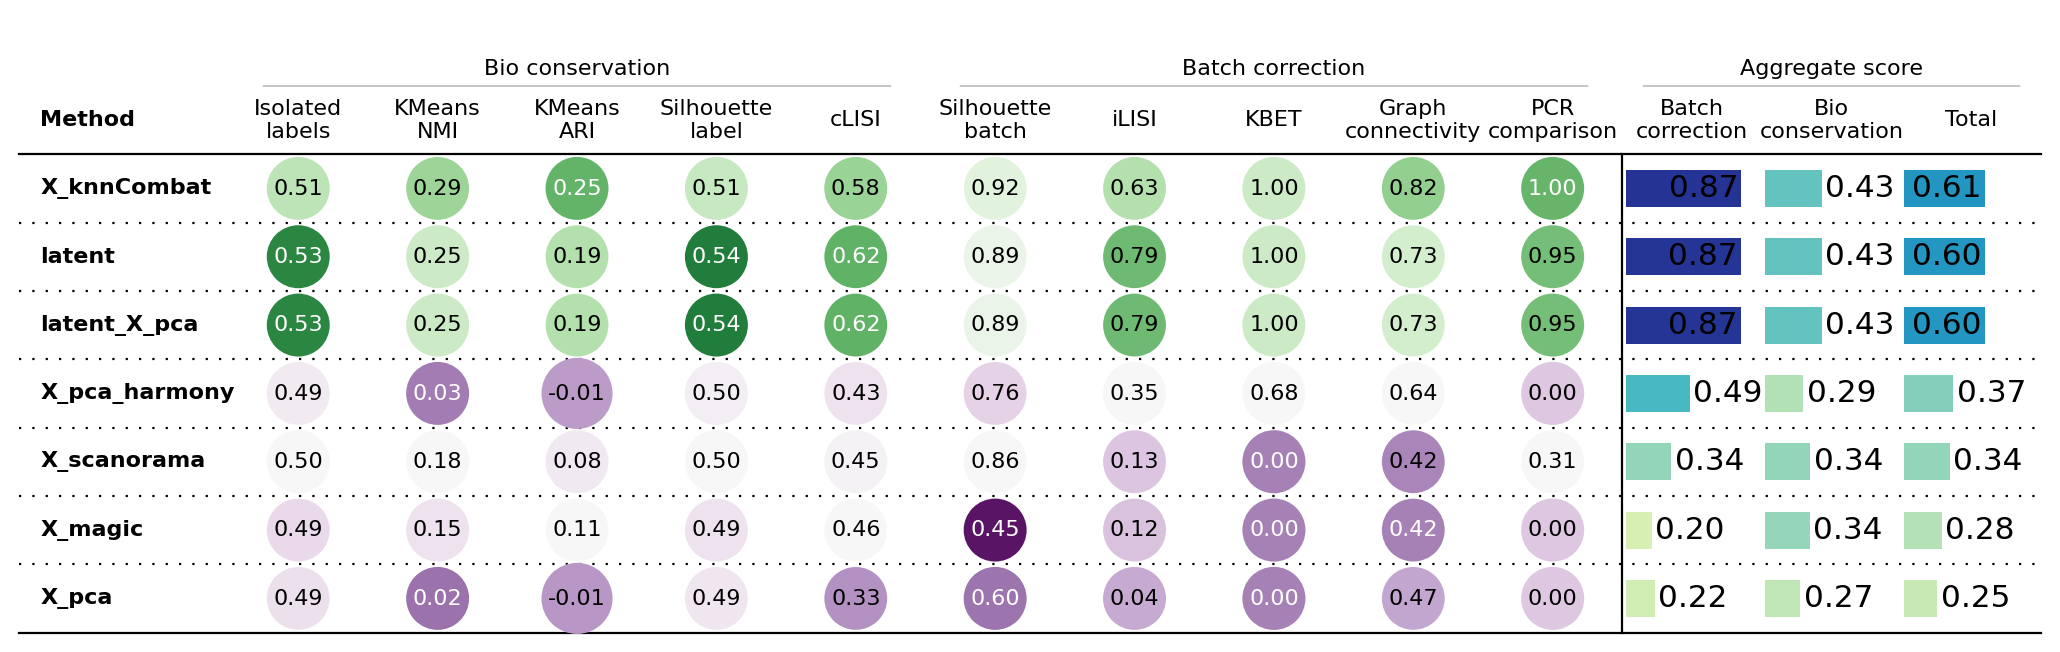

In [62]:
bm.plot_results_table(min_max_scale=False) 